<a href="https://colab.research.google.com/github/ExoticCoder16/ExoticCoder16-.github.io/blob/main/notebooks/how-to-auto-train-yolov8-model-with-autodistill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://ik.imagekit.io/roboflow/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Auto Train YOLOv8 Model with Autodistill

Autodistill uses big, slower foundation models to train small, faster supervised models. Using `autodistill`, you can go from unlabeled images to inference on a custom model running at the edge with no human intervention in between.

![Autodistill Steps](https://media.roboflow.com/open-source/autodistill/steps.jpg)

As foundation models get better and better they will increasingly be able to augment or replace humans in the labeling process. We need tools for steering, utilizing, and comparing these models. Additionally, these foundation models are big, expensive, and often gated behind private APIs. For many production use-cases, we need models that can run cheaply and in realtime at the edge.

![Autodistill Connections](https://media.roboflow.com/open-source/autodistill/connections.jpg)

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Image dataset preperation
- Autolabel dataset
- Train target model
- Evaluate target model
- Run video inference
- Upload dataset and model to Roboflow (comming soon)

## 🔥 Let's begin!


## ⚡ Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Mon Jul  3 06:52:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 🧪 Install autodistill

**NOTE:** Autodistill is an ecosystem for using big, slower foundation models to train small, faster supervised models. Each Base, as well as the Target model, has its own separate repository and pip package.

In [3]:
!pip install -q \
autodistill \
autodistill-grounded-sam \
autodistill-yolov8 \
supervision==0.9.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.4/82.4 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.0/527.0 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 105.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 87.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 113.9 MB/s eta 0:00:00


**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [4]:
import os
HOME = os.getcwd()
print(HOME)

/content


## 🖼️ Image dataset preperation

**NOTE:** To use Autodistill all you need to have is a set of images that you want to automatically annotate, and use for target model training.

In [5]:
!mkdir {HOME}/images

**NOTE:** If you want to build YOLOv8 on your data make sure to upload it into `images` directory that we just created. ☝️

### Download raw videos (optional)

**NOTE:** In this tutorial, we will start with a directory containing video files and I will show you how to turn it into a ready-to-use collection of images. If you are working with your images, you can skip this part.

In [ ]:
!mkdir {HOME}/videos
%cd {HOME}/videos

# download zip file containing videos
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1wnW7v6UTJZTAcOQj0416ZbQF8b7yO6Pt' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1wnW7v6UTJZTAcOQj0416ZbQF8b7yO6Pt" -O milk.zip && rm -rf /tmp/cookies.txt

# unzip videos
!unzip milk.zip

# **I skipped the above cell and directly mounted on Rarbit Google Drive**

In [6]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Convert videos into images (optional)

**NOTE:** Now, let's convert videos into images. By default, the code below saves every `10th` frame from each video. You can change this by manipulating the value of the `FRAME_STRIDE` parameter.

In [7]:
# VIDEO_DIR_PATH = f"{HOME}/videos"
VIDEO_DIR_PATH = f"{HOME}/gdrive/MyDrive/videos"
IMAGE_DIR_PATH = f"{HOME}/images"
FRAME_STRIDE = 10

**NOTE:** Notice that we put two of our videos aside so that we can use them at the end of the notebook to evaluate our model.

In [8]:
import supervision as sv
from tqdm.notebook import tqdm

video_paths = sv.list_files_with_extensions(
    directory=VIDEO_DIR_PATH,
    extensions=["mov", "mp4"])

TEST_VIDEO_PATHS, TRAIN_VIDEO_PATHS = video_paths[:2], video_paths[2:]

for video_path in tqdm(TRAIN_VIDEO_PATHS):
    video_name = video_path.stem
    image_name_pattern = video_name + "-{:05d}.png"
    with sv.ImageSink(target_dir_path=IMAGE_DIR_PATH, image_name_pattern=image_name_pattern) as sink:
        for image in sv.get_video_frames_generator(source_path=str(video_path), stride=FRAME_STRIDE):
            sink.save_image(image=image)

  0%|          | 0/2 [00:00<?, ?it/s]

### Display image sample

**NOTE:** Before we start building a model with autodistill, let's make sure we have everything we need.

In [9]:
import supervision as sv

image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpg"])

print('image count:', len(image_paths))

image count: 210


**NOTE:** We can also plot sample of our image dataset.

In [10]:
IMAGE_DIR_PATH = f"{HOME}/images"
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

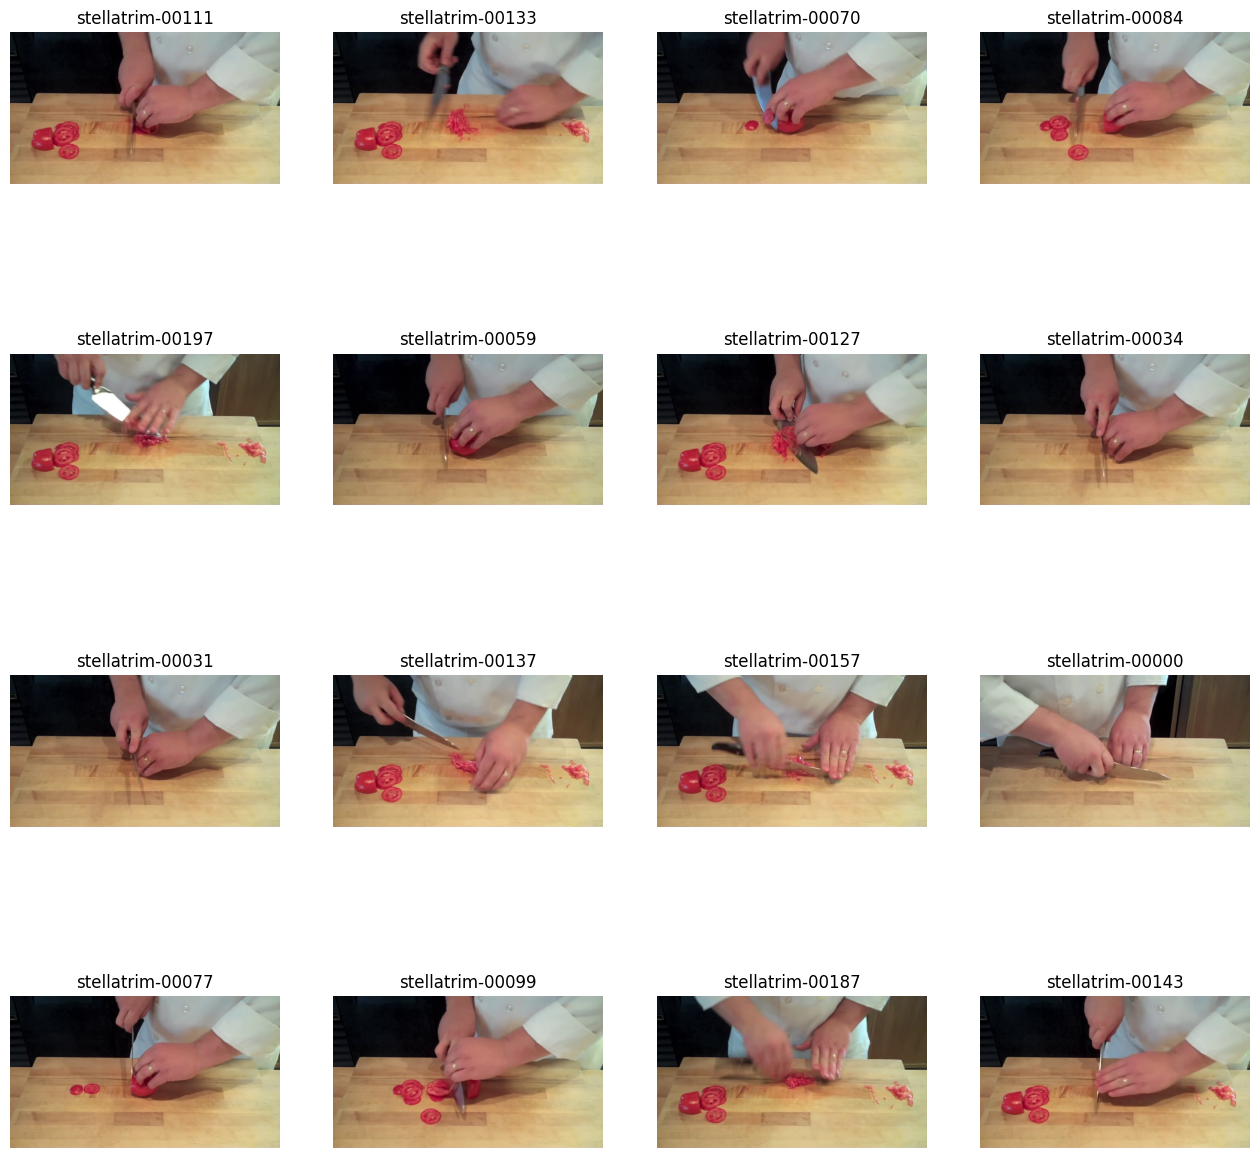

In [11]:
import cv2
import supervision as sv

titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

## 🏷️ Autolabel dataset

### Define ontology

**Ontology** - an Ontology defines how your Base Model is prompted, what your Dataset will describe, and what your Target Model will predict. A simple Ontology is the CaptionOntology which prompts a Base Model with text captions and maps them to class names. Other Ontologies may, for instance, use a CLIP vector or example images instead of a text caption.

In [ ]:
from autodistill.detection import CaptionOntology

ontology=CaptionOntology({
    "milk bottle": "bottle",
    "blue cap": "cap"
})

In [16]:
from autodistill.detection import CaptionOntology

ontology=CaptionOntology({
    "hand holding knife" : "hand holdoing knife"
})

### Initiate base model and autolabel

**Base Model** - A Base Model is a large foundation model that knows a lot about a lot. Base models are often multimodal and can perform many tasks. They're large, slow, and expensive. Examples of Base Models are GroundedSAM and GPT-4's upcoming multimodal variant. We use a Base Model (along with unlabeled input data and an Ontology) to create a Dataset.

In [17]:
DATASET_DIR_PATH = f"{HOME}/dataset"

**NOTE:** Base Models are slow... Make yourself a coffee, autolabeing may take a while. ☕

In [18]:
from autodistill_grounded_sam import GroundedSAM

base_model = GroundedSAM(ontology=ontology)
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".png",
    output_folder=DATASET_DIR_PATH)

trying to load grounding dino directly
downloading dino model weights


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Labeling /content/images/stellatrim-00111.png:   0%|          | 0/210 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:884: FutureWarning: The `device`

Labeled dataset created - ready for distillation.


### Display dataset sample

**Dataset** - a Dataset is a set of auto-labeled data that can be used to train a Target Model. It is the output generated by a Base Model.

In [19]:
ANNOTATIONS_DIRECTORY_PATH = f"{HOME}/dataset/train/labels"
IMAGES_DIRECTORY_PATH = f"{HOME}/dataset/train/images"
DATA_YAML_PATH = f"{HOME}/dataset/data.yaml"

In [20]:
import supervision as sv

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

168

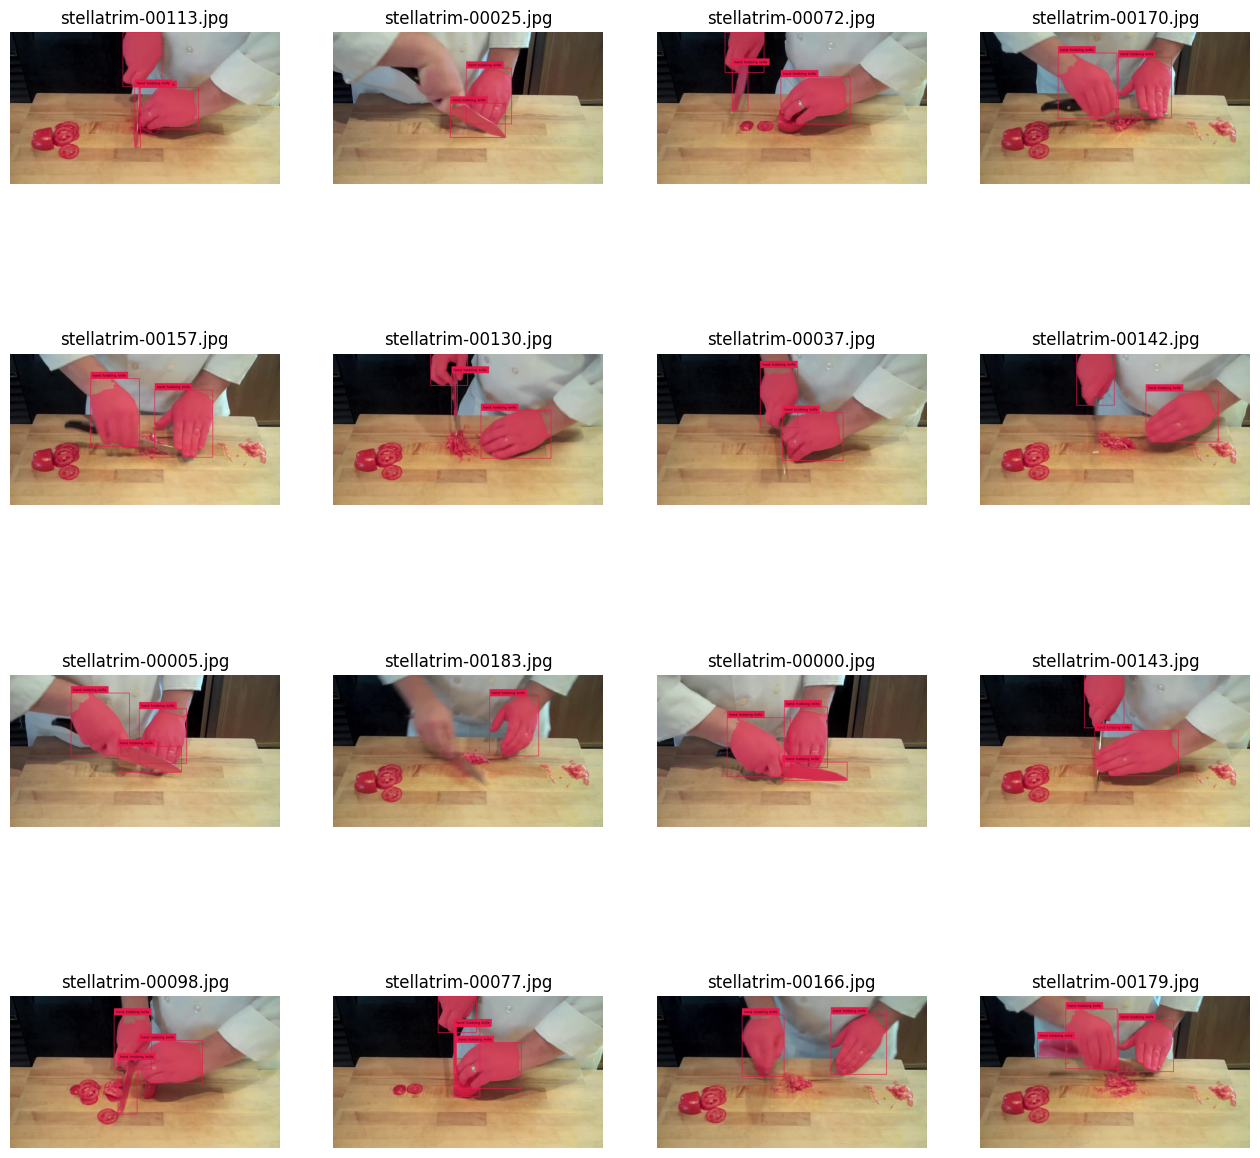

In [21]:
import supervision as sv

image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

## 🔥 Train target model - YOLOv8

**Target Model** - a Target Model is a supervised model that consumes a Dataset and outputs a distilled model that is ready for deployment. Target Models are usually small, fast, and fine-tuned to perform a specific task very well (but they don't generalize well beyond the information described in their Dataset). Examples of Target Models are YOLOv8 and DETR.

In [22]:
%cd {HOME}

from autodistill_yolov8 import YOLOv8

target_model = YOLOv8("yolov8n.pt")
target_model.train(DATA_YAML_PATH, epochs=50)

/content


100%|██████████| 6.23M/6.23M [00:00<00:00, 119MB/s]
New https://pypi.org/project/ultralytics/8.0.124 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/dataset/data.yaml, epochs=50, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, aug

Import the following code to avoid the error I ran in : ***NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968***



In [40]:
import locale
def getpreferredencoding(do_setlocale = True )
  return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [41]:
!ls {HOME}/runs/detect/train/

args.yaml					   results.png
confusion_matrix.png				   train_batch0.jpg
events.out.tfevents.1688368365.6352e01b77f1.337.0  train_batch1.jpg
F1_curve.png					   train_batch2.jpg
labels_correlogram.jpg				   val_batch0_labels.jpg
labels.jpg					   val_batch0_pred.jpg
P_curve.png					   val_batch1_labels.jpg
PR_curve.png					   val_batch1_pred.jpg
R_curve.png					   weights
results.csv


## ⚖️ Evaluate target model

**NOTE:** As with the regular YOLOv8 training, we can now take a look at artifacts stored in `runs` directory.

/content


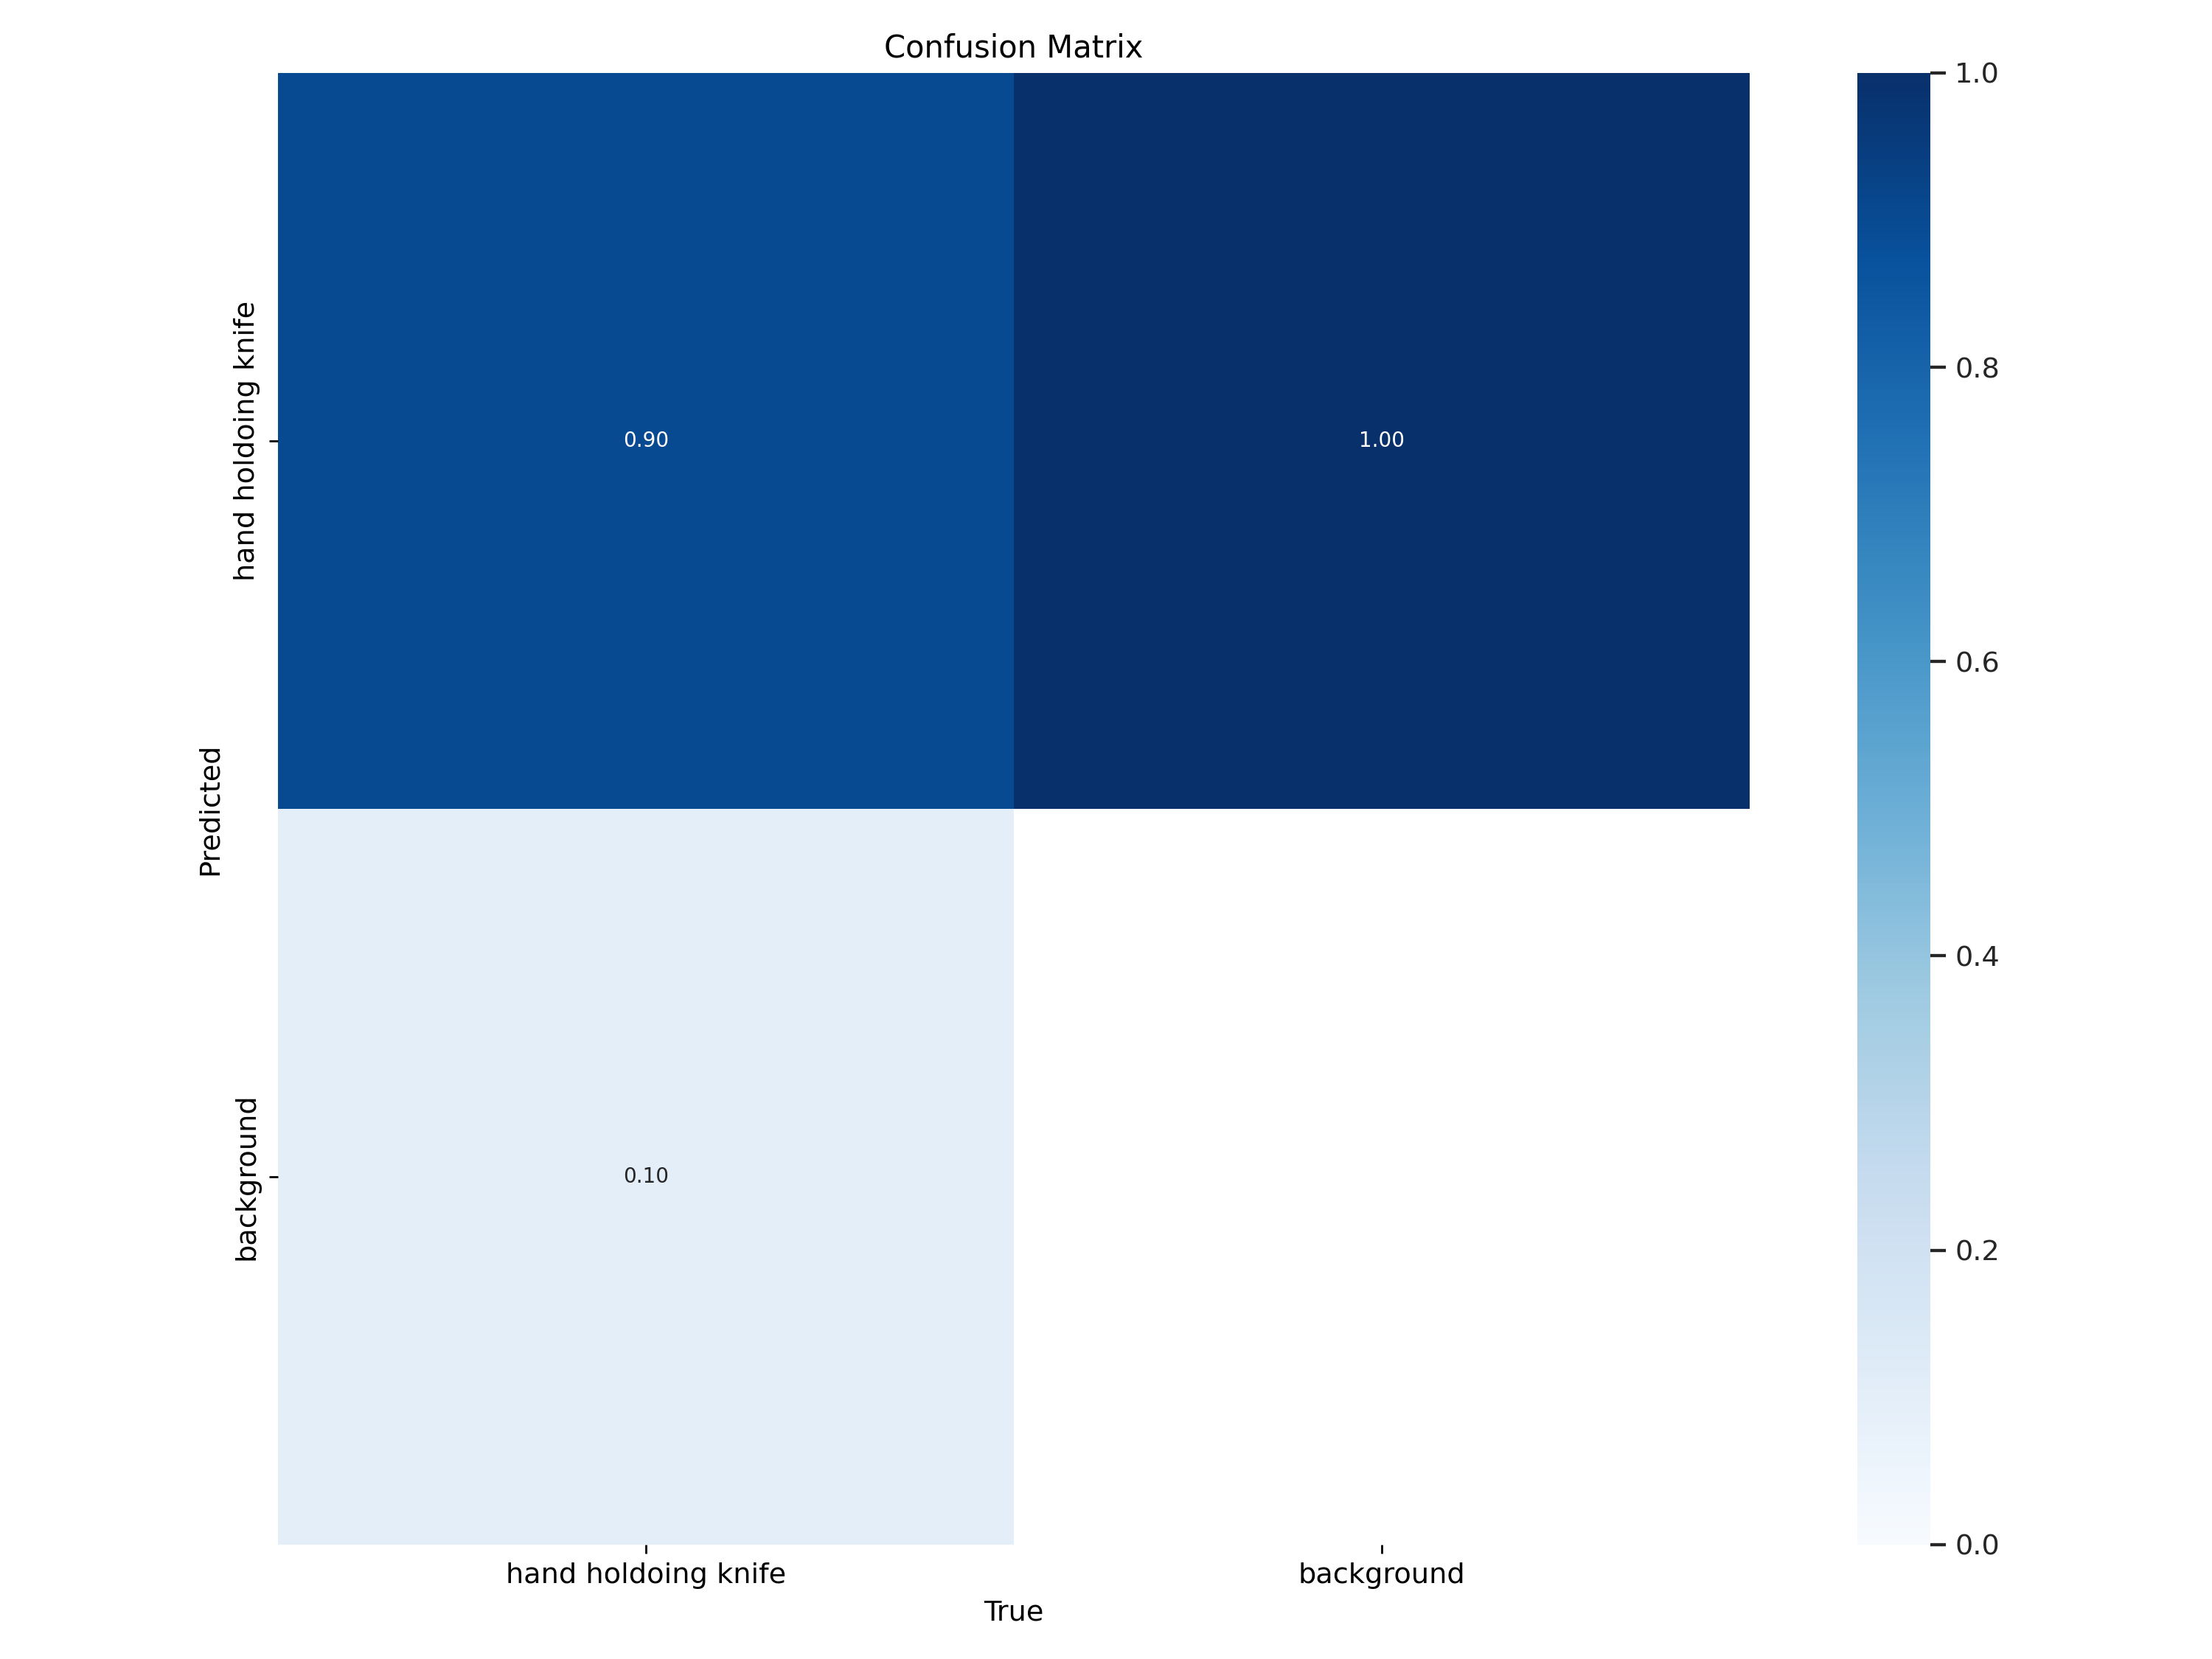

In [28]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/content


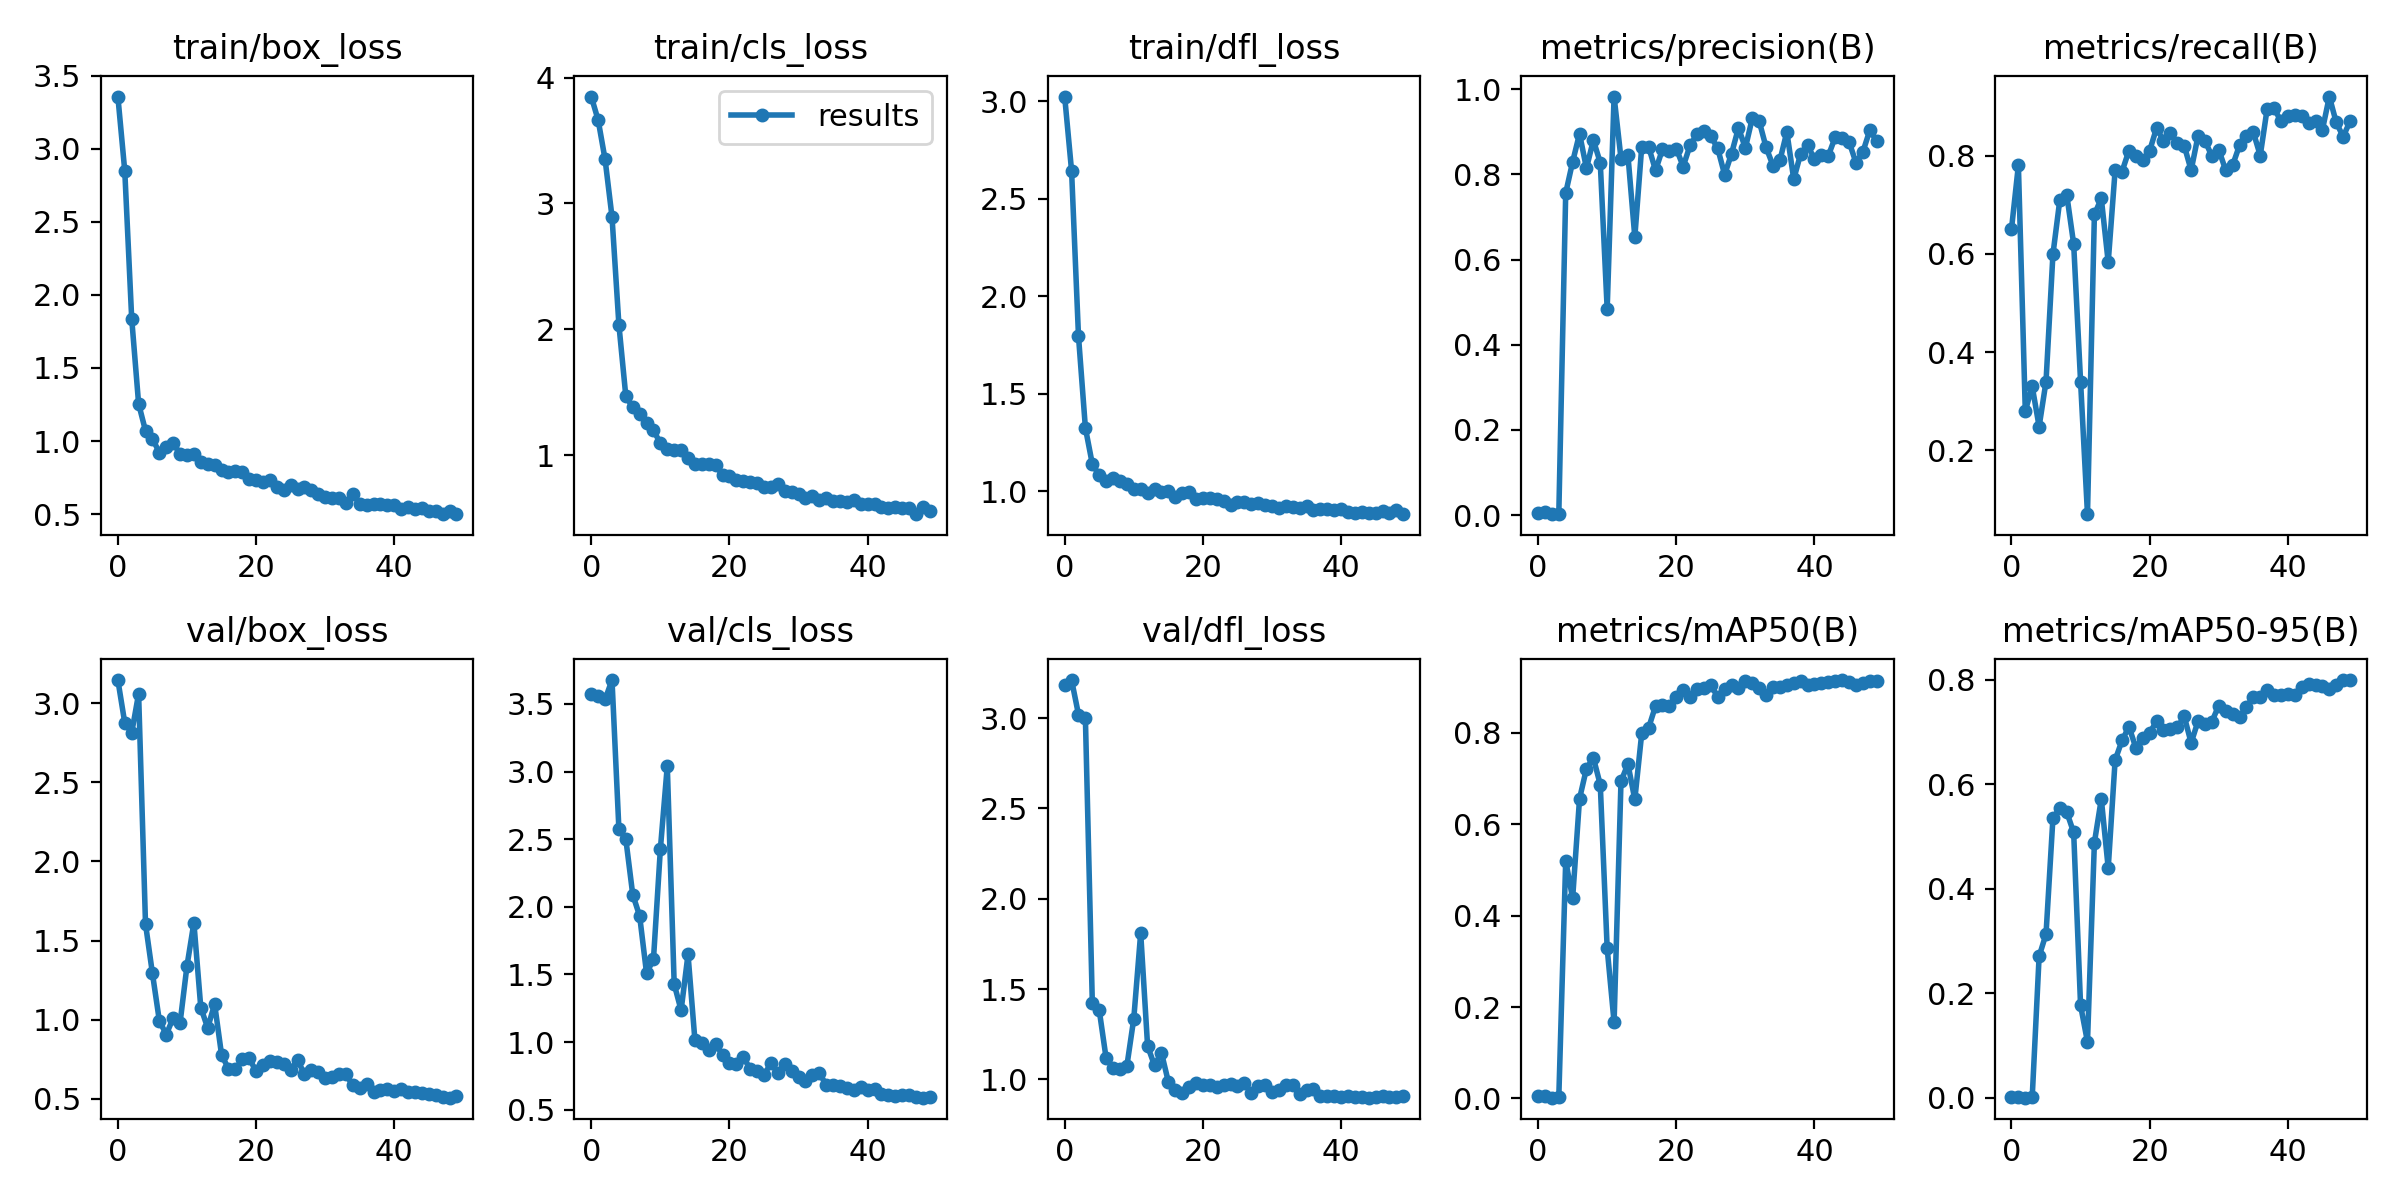

In [29]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

/content


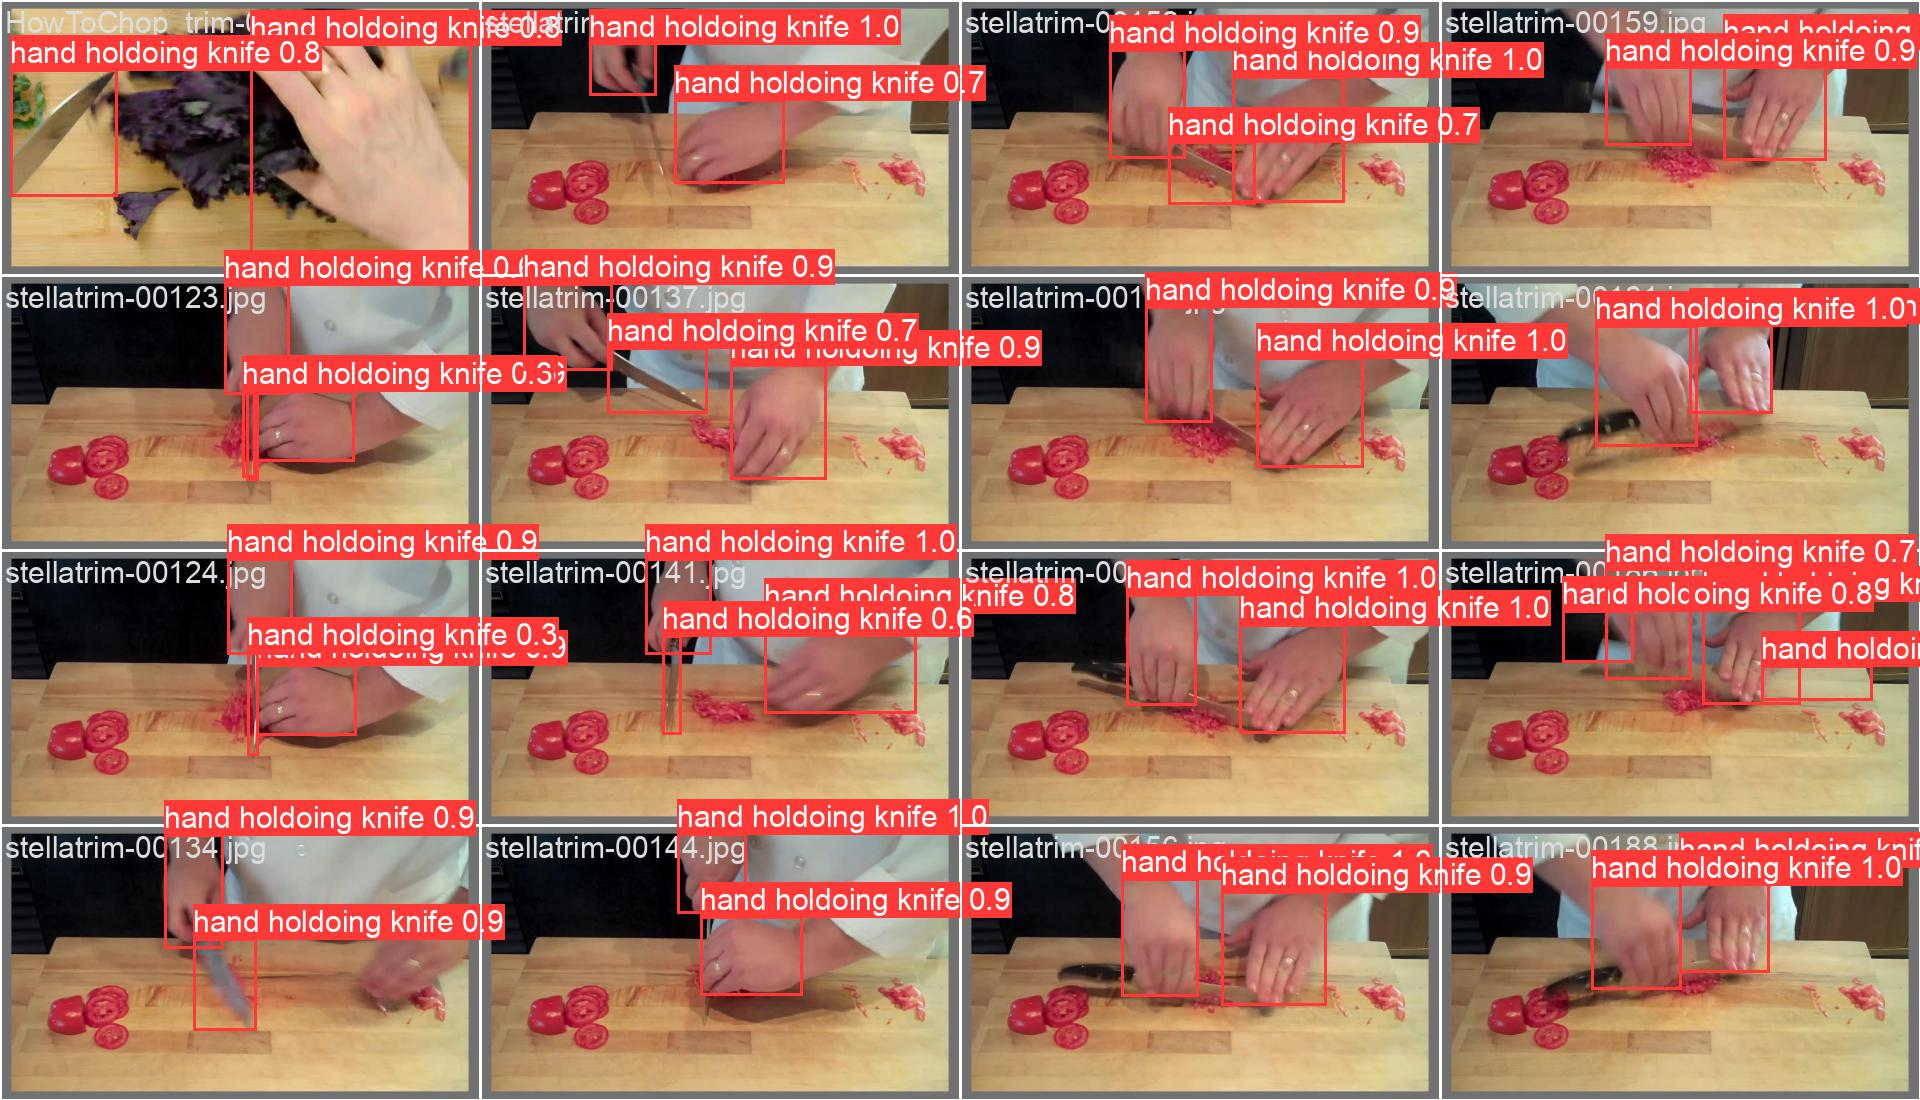

In [30]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## 🎬 Run Inference on a video

In [31]:
INPUT_VIDEO_PATH = TEST_VIDEO_PATHS[0]
OUTPUT_VIDEO_PATH = f"{HOME}/output.mp4"
TRAINED_MODEL_PATH = f"{HOME}/runs/detect/train/weights/best.pt"

Import the following code to avoid the error I ran in : ***NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968***

In [37]:
import locale
def getpreferredencoding(do_setlocale = True ):
  return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [38]:
!yolo predict model={TRAINED_MODEL_PATH} source={INPUT_VIDEO_PATH}

Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

video 1/1 (1/43) /content/gdrive/MyDrive/videos/trim.mp4: 384x640 3 hand holdoing knifes, 83.5ms
video 1/1 (2/43) /content/gdrive/MyDrive/videos/trim.mp4: 384x640 3 hand holdoing knifes, 13.1ms
video 1/1 (3/43) /content/gdrive/MyDrive/videos/trim.mp4: 384x640 3 hand holdoing knifes, 12.0ms
video 1/1 (4/43) /content/gdrive/MyDrive/videos/trim.mp4: 384x640 3 hand holdoing knifes, 10.4ms
video 1/1 (5/43) /content/gdrive/MyDrive/videos/trim.mp4: 384x640 3 hand holdoing knifes, 26.4ms
video 1/1 (6/43) /content/gdrive/MyDrive/videos/trim.mp4: 384x640 3 hand holdoing knifes, 11.9ms
video 1/1 (7/43) /content/gdrive/MyDrive/videos/trim.mp4: 384x640 3 hand holdoing knifes, 8.6ms
video 1/1 (8/43) /content/gdrive/MyDrive/videos/trim.mp4: 384x640 3 hand holdoing knifes, 11.2ms
video 1/1 (9/43) /content/gdrive/MyDrive/videos/trim.mp4: 

## Upload dataset and model to Roboflow

comming soon...

  # 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.